# Topic Detection

## Description
Perform topic detection.

## Setup

### Libraries (Pyhton)

In [ ]:
from bertopic import BERTopic
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import copy
import igraph as ig
import json
import networkx as nx
import numpy as np
import os
import pandas as pd
import pickle
from pathlib import Path
import scipy.sparse as sps
import sys
from tqdm import tqdm
import umap
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    import louvain

### Directories

In [2]:
try:
    BASE_DIR = Path(__file__).resolve().parent
except NameError:
    BASE_DIR = Path().resolve()

SRC_DIR = BASE_DIR / 'src'
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

DATA_DIR = BASE_DIR / 'data'
DATA_DIR.mkdir(exist_ok=True)
POSTS_DIR = DATA_DIR / 'posts'
POSTS_ALL_DIR = POSTS_DIR / 'all'
POSTS_FILTERED_DIR = POSTS_DIR / 'filtered'
POSTS_FILTERED_CLEAN_DIR = POSTS_FILTERED_DIR / 'clean'
COMMENTS_DIR = DATA_DIR / 'comments'
COMMENTS_CLEAN_DIR = COMMENTS_DIR / 'clean'
RESULTS_DIR = BASE_DIR / 'results'
RESULTS_GRAPHS_DIR = RESULTS_DIR / 'graphs'
RESULTS_MODELS_DIR = RESULTS_DIR / 'models'
RESULTS_MODELS_DIR.mkdir(exist_ok=True)
RESULTS_MODELS_FILE = RESULTS_MODELS_DIR / 'model_results.csv'

### Libraries (Custom)

In [ ]:
import topic as t
import metrics as met

## Import Data

In [4]:
# Graph
filename = RESULTS_GRAPHS_DIR / 'g_dd.graphml'
g_dd_nx = nx.read_graphml(str(filename))
g_dd = ig.Graph.from_networkx(g_dd_nx)

print(g_dd.summary())

IGRAPH UNW- 15819 924974 -- 
+ attr: edge_default (g), node_default (g), _nx_name (v), name (v), weight (e)


In [5]:
# Matrices
filename_pickle_gdd = RESULTS_GRAPHS_DIR / 'g_dd.pickle'
with open(filename_pickle_gdd , 'rb') as f:
    g_dd_matrices = pickle.load(f)

In [19]:
# Original documents
filename_df = DATA_DIR / 'df_dd.json'
df_dd = pd.read_json(str(filename_df), lines=True)

In [7]:
# Load BERTopic model
filepath_bert = RESULTS_MODELS_DIR / 'bert'
bert_model = BERTopic.load(str(filepath_bert))

In [5]:
# Check basic stats
print("--- Document-Projected Network (Giant Component) ---")
print(f"Size: {g_dd.vcount()}")
print(f"Average degree: {np.mean(g_dd.degree()):.2f}")
print(f"Median degree: {np.median(g_dd.degree()):.2f}")
print(f"Density: {g_dd.density():.5f}")
print(f"Diameter: {g_dd.diameter(directed=False, unconn=False):.2f}")
print(f"Average path length: {g_dd.average_path_length():.5f}")

--- Document-Projected Network (Giant Component) ---
Size: 15819
Average degree: 116.94
Median degree: 50.00
Density: 0.00739
Diameter: 6.00
Average path length: 2.51146


## Louvain [NO NEED TO RE-RUN]

In [ ]:
# Partition
partition_louvain = louvain.find_partition(g_dd, louvain.ModularityVertexPartition, weights='weight', seed=42)
print(f"Number of communities: {len(partition_louvain)}")

# Access community assignments
membership_louvain = partition_louvain.membership
topics = np.array(membership_louvain)

Number of communities: 13


In [ ]:
# Get document IDs and corresponding Louvain topics
louvain_df = pd.DataFrame({
    'document_id': g_dd.vs['name'],
    'louvain_topic': partition_louvain.membership
})

# df_dd = df_dd.merge(louvain_df, on='document_id', how='left')

In [ ]:
# Save to JSON
# df_dd.to_json(DATA_DIR / 'df_dd.json', orient='records', lines=True)

### View Basic Info

In [ ]:
# View counts
topic_counts = Counter(membership_louvain)

for topic in sorted(topic_counts):
    print(f"Topic {topic} has {topic_counts[topic]} documents")

Topic 0 has 4529 documents
Topic 1 has 3176 documents
Topic 2 has 2563 documents
Topic 3 has 1147 documents
Topic 4 has 1116 documents
Topic 5 has 899 documents
Topic 6 has 746 documents
Topic 7 has 677 documents
Topic 8 has 616 documents
Topic 9 has 176 documents
Topic 10 has 94 documents
Topic 11 has 75 documents
Topic 12 has 5 documents


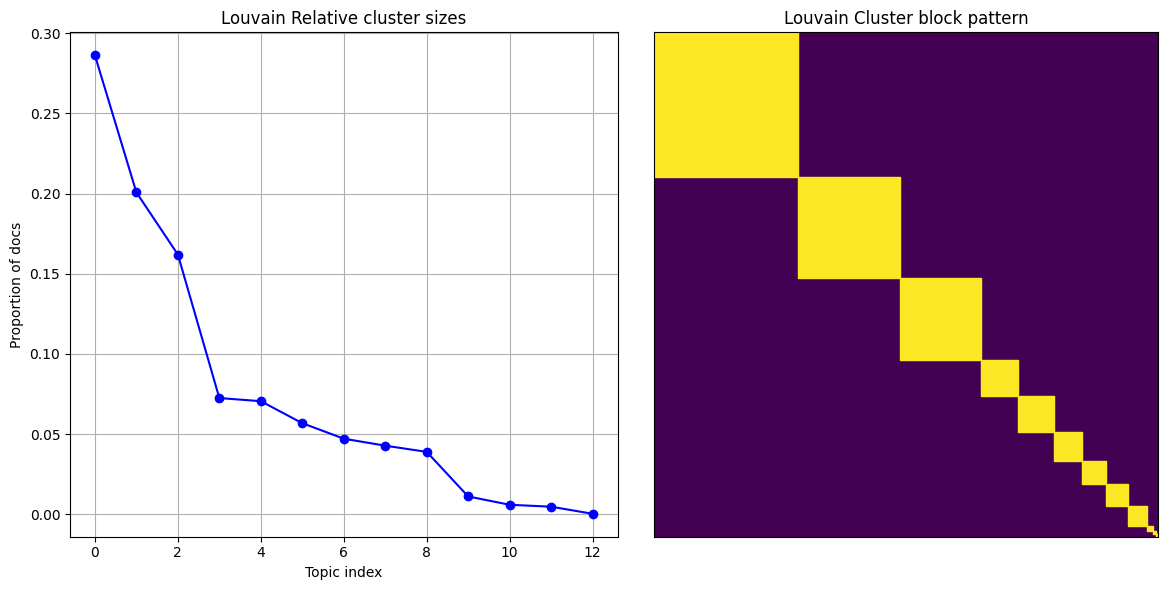

In [13]:
# Plot CtC
num_docs, num_topics, C = t.extract_community_assignments(topics, topic_ids_start=1)
t.plot_topic_pattern(num_docs, C, title_1='Louvain Relative cluster sizes', title_2='Louvain Cluster block pattern')

### Metrics
Modularity, NMI, Ncut.

In [11]:
# Normalize existing matrices
Pwd = g_dd_matrices['Pwd'] / g_dd_matrices['Pwd'].sum()
Pdd = g_dd_matrices['Pdd'] / g_dd_matrices['Pdd'].sum()

In [ ]:
# Update topic matrices
Pwc = Pwd.dot(C)              # Joint word + class probability
Pcc = ((C.T).dot(Pdd)).dot(C) # Joint class + class probability
pc = Pcc.sum(axis=0)          # Topic co-occurrence weights (node strength of each topic in the topic co-occurrence matrix)

In [13]:
# Initialize results dict
model_name = 'Louvain'
metric_names = ['Modularity', 'Ncut', 'NMI']
metrics = {model_name: {metric: np.nan for metric in metric_names}}

In [14]:
# Compute metrics
metrics[model_name]['Modularity'] = met.calculate_modularity(Pcc)
metrics[model_name]['Ncut'] = met.calculate_ncut(Pcc)
metrics[model_name]['NMI'] = met.calculate_nmi(Pwc)

# Print results
print(f"NMI: {metrics[model_name]['NMI']:.4f}")
print(f"Modularity: {metrics[model_name]['Modularity']:.4f}")
print(f"Ncut: {metrics[model_name]['Ncut']:.4f}")

met.save_results_to_csv(RESULTS_MODELS_FILE, metrics, metric_names, model_name)
print("Results saved to .csv")

NMI: 0.1194
Modularity: 0.2705
Ncut: 0.5759
Results saved to .csv


### Topic interpretation

#### Fine-tune with GPT [NO NEED TO RUN]

In [15]:
# Get representative documents
repr_docs_idx_louvain = t.get_louvain_community_reps(g_dd, topics, top_k=10)
doc_id_to_text = dict(zip(df_dd['document_id'], df_dd['og_text']))

# Build the new dictionary
repr_docs_text_louvain = {
    topic: [doc_id_to_text[doc_id] for doc_id in doc_ids if doc_id in doc_id_to_text]
    for topic, doc_ids in repr_docs_idx_louvain.items()
}

In [ ]:
# Prepare dictionary for fine-tuned labels
# topic_labels = {i: {} for i in range(13)}

Prompt ChatGPT (each topic requires a new chat) with:

Based on the following documents from the same topic, generate:
    1. A concise topic label (3–6 words).
    2. A short summary (1–2 sentences) describing the topic's content.

"Documnt 1: ... "
"Document 2: ... "
"Document 3: ... "
"Document 4: ... "
"Document 5: ... "
"Document ... "

In [ ]:
# Print top documents in a topic
# topic_number = 12
# t.print_top_docs(topic_number, repr_docs_text_louvain)

In [ ]:
# Update topics with fine-tuned labels and summaries
# topic_labels[topic_number]['gpt_label'] = "r/ewphoria Reddit Community"
# topic_labels[topic_number]['gpt_summary'] = "The documents all reference the Reddit community r/ewphoria, highlighting posts and content that members of this subreddit would appreciate or find relevant. The focus is on shared enjoyment and recognition of specific types of content within this group."

# Check correctness
# print(f"Topic: {topic_number}")
# topic_labels[topic_number]

In [ ]:
# Save to JSON
# sorted_data = {k: topic_labels[k] for k in sorted(topic_labels, key=int)}
# filename_louvain_tuned_topics = RESULTS_MODELS_DIR / 'louvain' / 'fine_tuned_topics_sorted.json'
# with open(filename_louvain_tuned_topics, 'w') as file:
    # json.dump(sorted_data, file, indent=4)

In [16]:
# Load JSON
filename_louvain_tuned_topics = RESULTS_MODELS_DIR / 'louvain' / 'fine_tuned_topics_sorted.json'
with open(filename_louvain_tuned_topics, 'r') as f:
    data = json.load(f)

topic_labels_louvain = {int(k): v for k, v in data.items()}
topic_labels_dict = {i+1: topic_labels_louvain[i]['gpt_label'] for i in range(13)}

### Visualize Topics

In [20]:
# Transform to BERTopic-style for visualization
louvain_to_bertopic_stile = t.to_bertopic_style(bert_model, list(df_dd['clean_text']), list(df_dd['louvain_topic']), fine_tuned_labels=topic_labels_dict)

In [55]:
louvain_to_bertopic_stile.visualize_barchart(top_n_topics=11, n_words=9, width=450, title="Louvain Topic Word Scores", custom_labels=True)

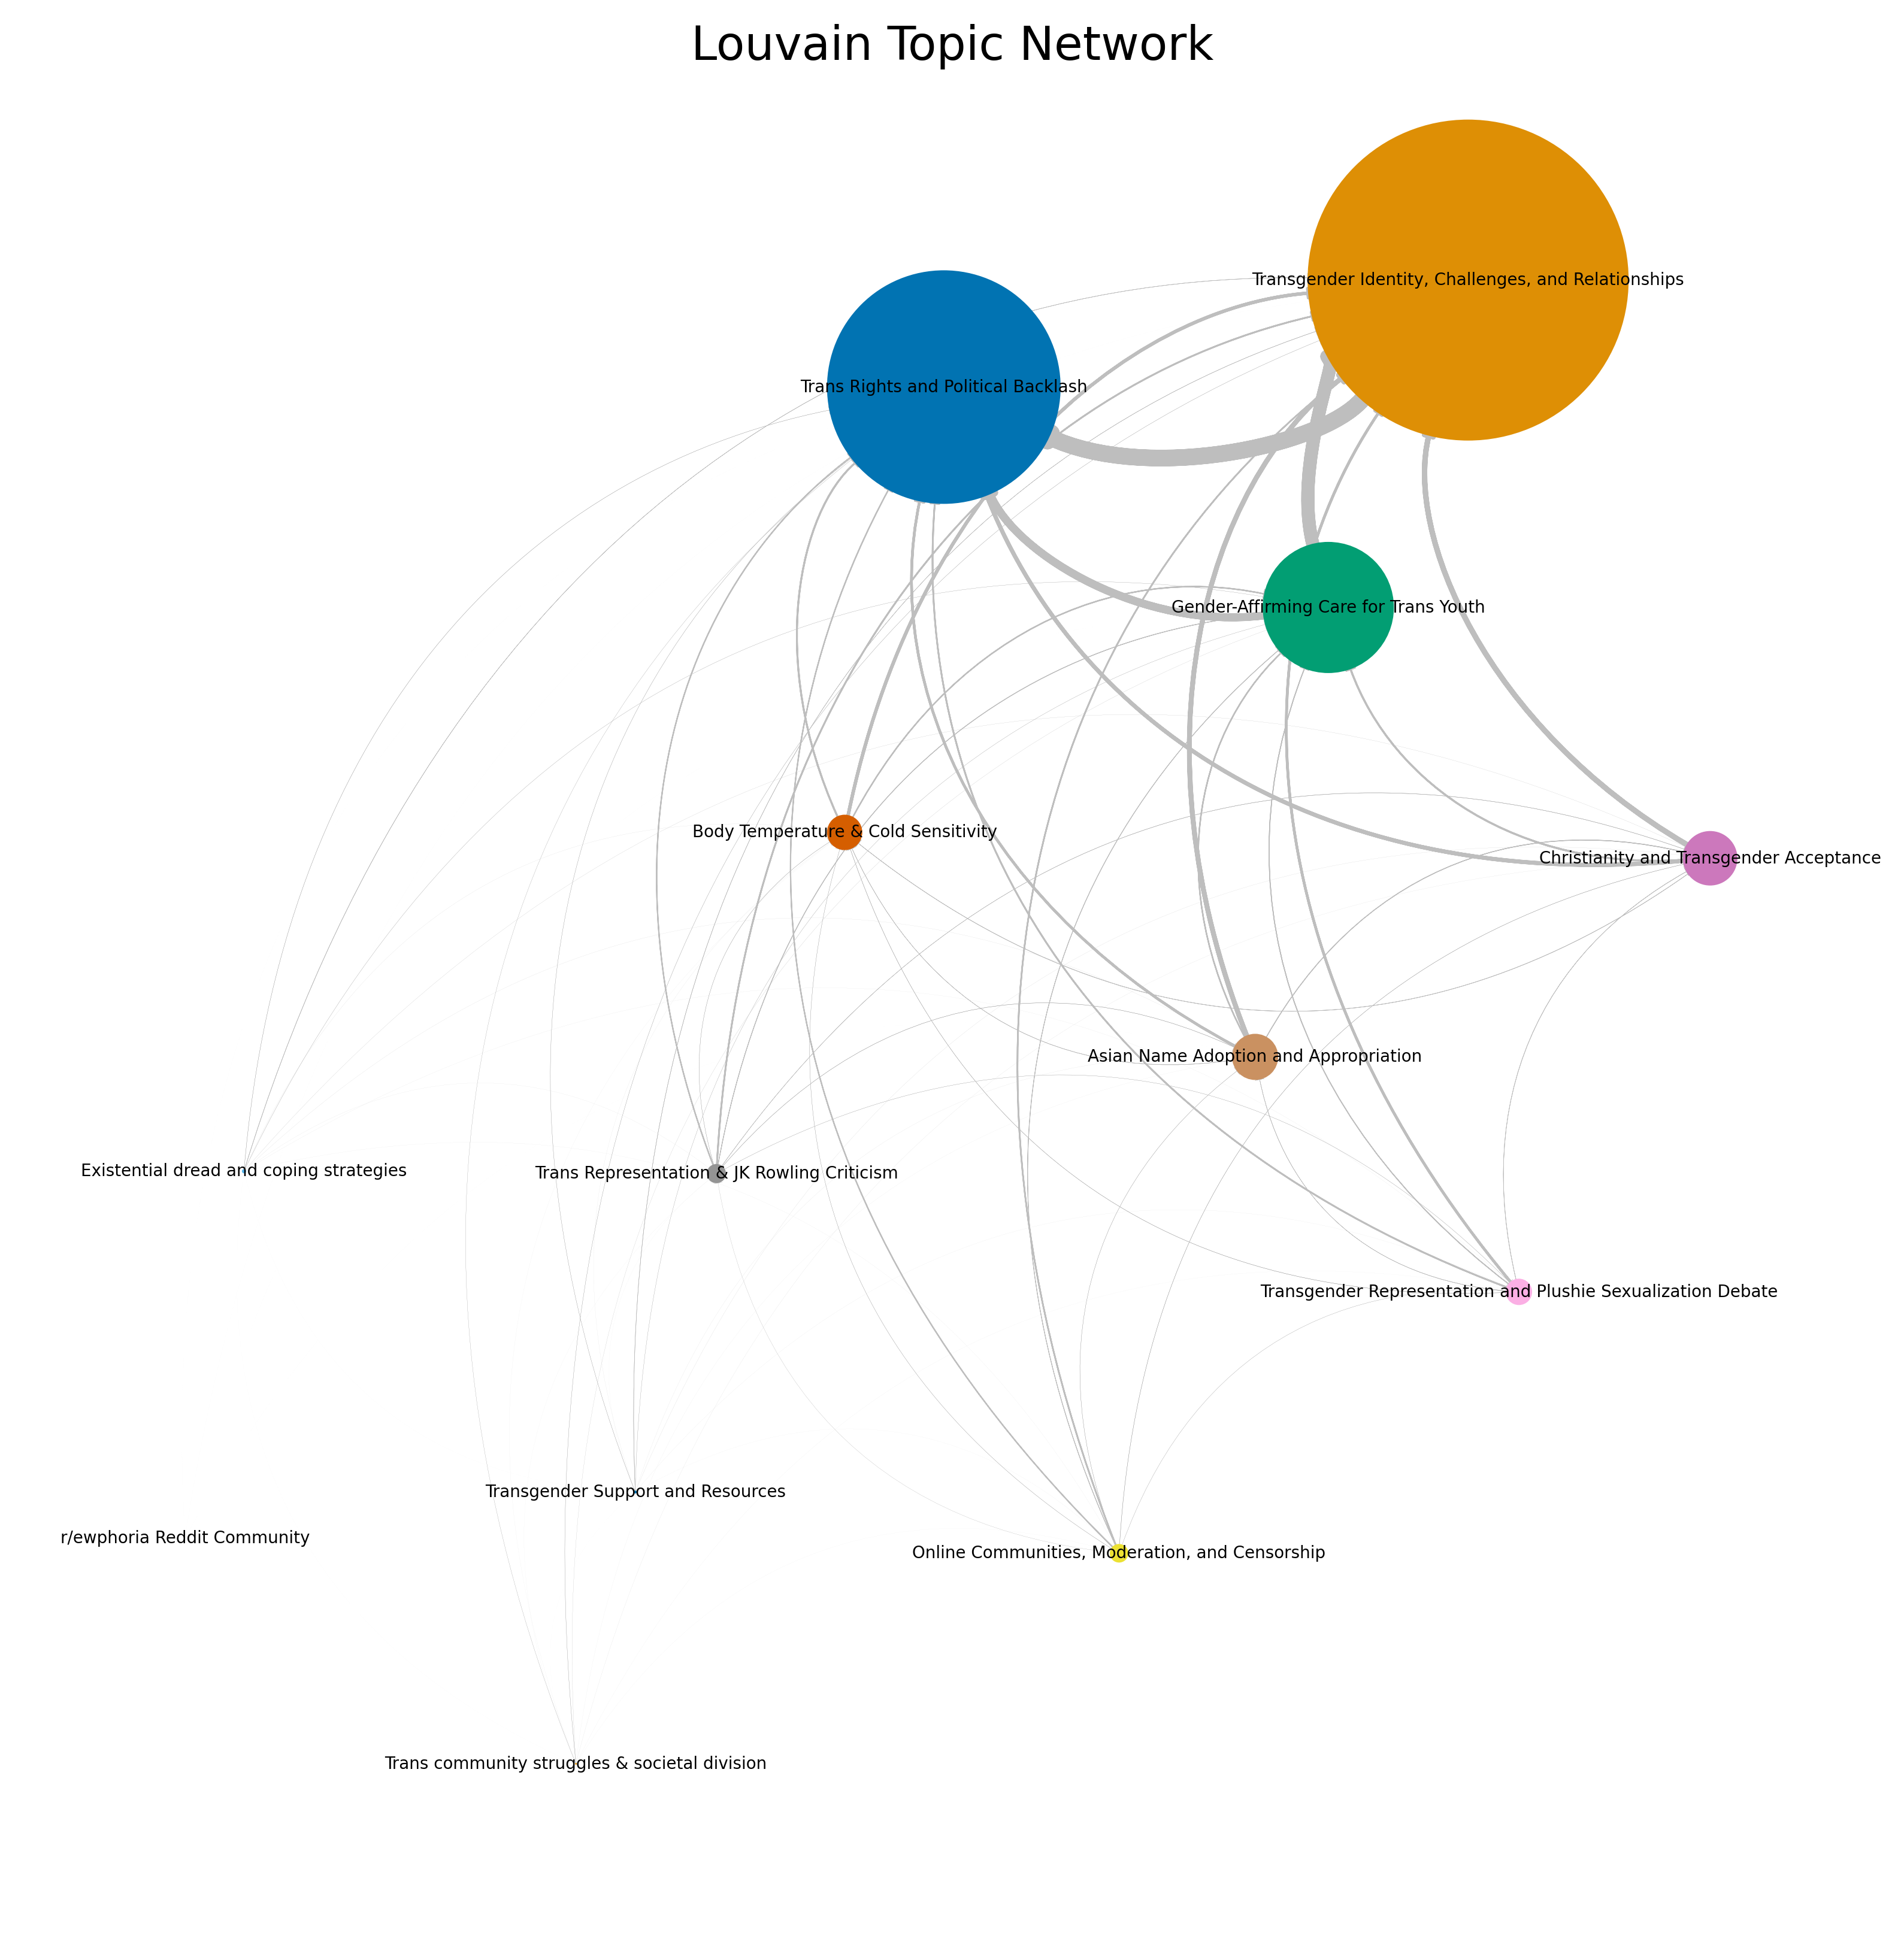

In [53]:
t.plot_topic_network_louvain(Pcc, pc, topic_labels=topic_labels_dict, title="Louvain Topic Network")

## Clear Allocated Memory

In [56]:
# Run before exiting the program to clear memory
%reset -f
import gc
gc.collect()

0